In [1]:
# Preamble
# ASSUMES NUMPY 1.26.1
import numpy as np
# ASSUMES PANDAS 2.2.2
import pandas as pd
# ASSUMES SEABORN 0.13.x
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.optimize as so
import statsmodels.api as sm
import statsmodels.formula.api as smf

run_data = pd.read_csv("runningSpeeds.csv")
run_data.head()

,Unnamed: 0,age,pace
0,0,38,3.73
1,1,75,7.53
2,2,35,4.73
3,3,27,4.26
4,4,54,5.40


# Data Exploration

## One-dimensional - Distribution Plots

<Axes: xlabel='age', ylabel='Count'>

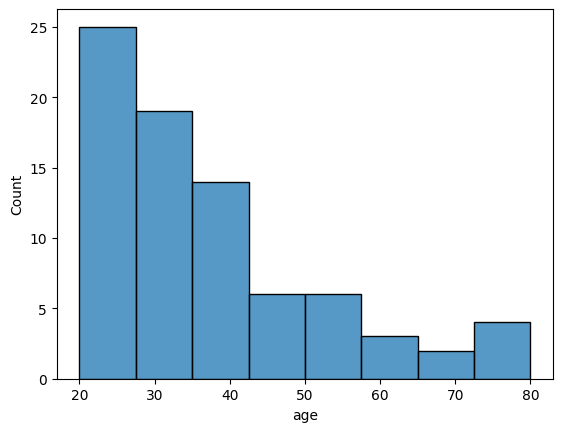

In [5]:
# Histogram
sns.histplot(run_data.age)

<Axes: xlabel='age', ylabel='Count'>

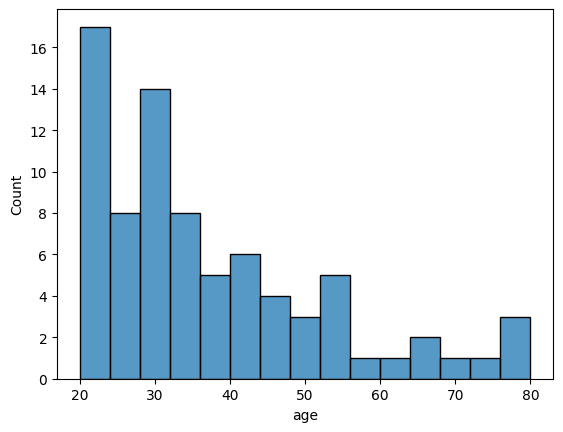

In [141]:
# Histogram - specify # bins
sns.histplot(run_data.age, bins = 15)

<Axes: xlabel='age', ylabel='Density'>

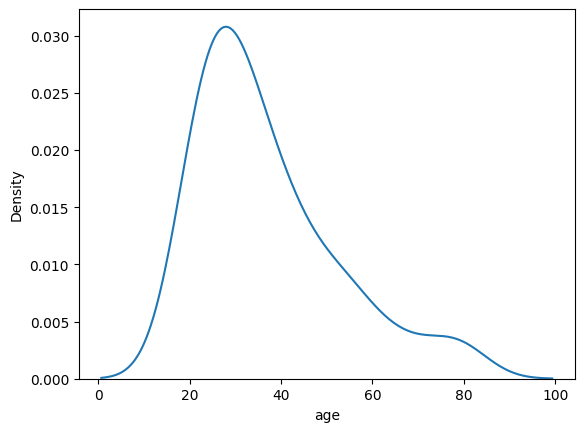

In [142]:
# Density estimate
sns.kdeplot(run_data.age)

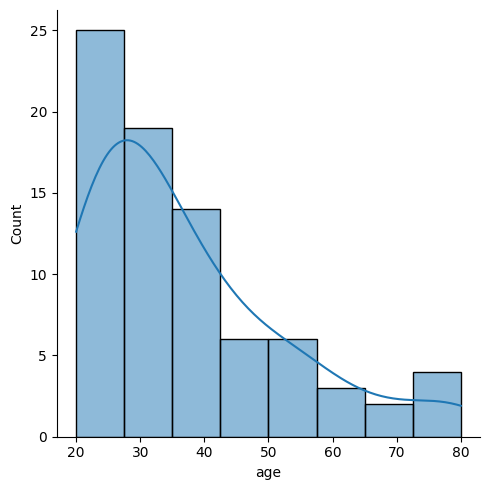

In [143]:
# Both histogram and density estimate
sns.displot(run_data.age, kde=True)

## Two-dimensional - Joint Plots

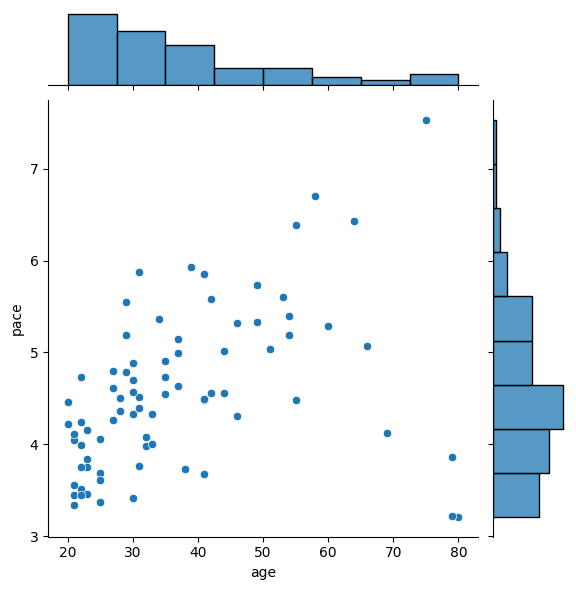

In [144]:
# Joint distribution plot
sns.jointplot(x="age", y="pace", data=run_data)

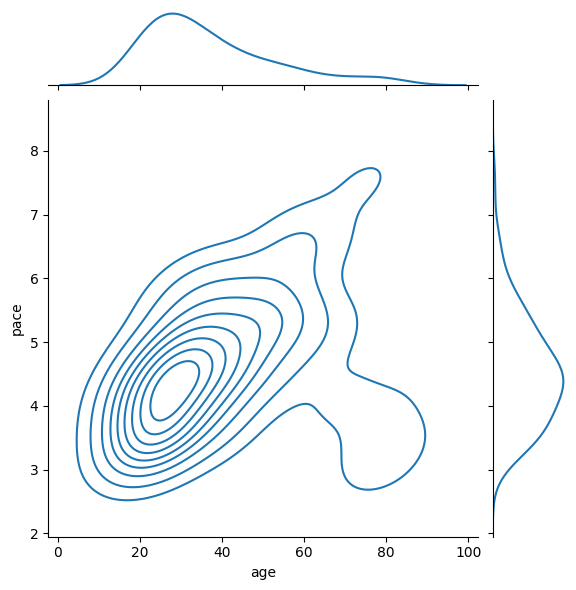

In [145]:
# Joint distribution plot with estimated density
sns.jointplot(x="age", y="pace", data=run_data, kind="kde")

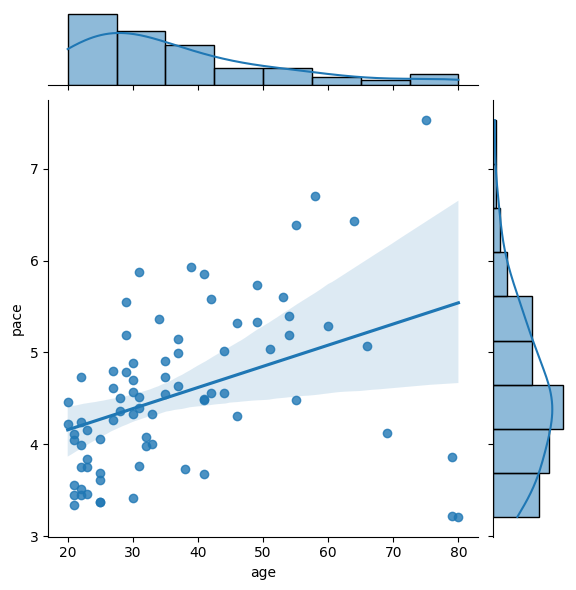

In [146]:
# Joint distribution plot with regression line
sns.jointplot(x="age", y="pace", data=run_data, kind="reg")

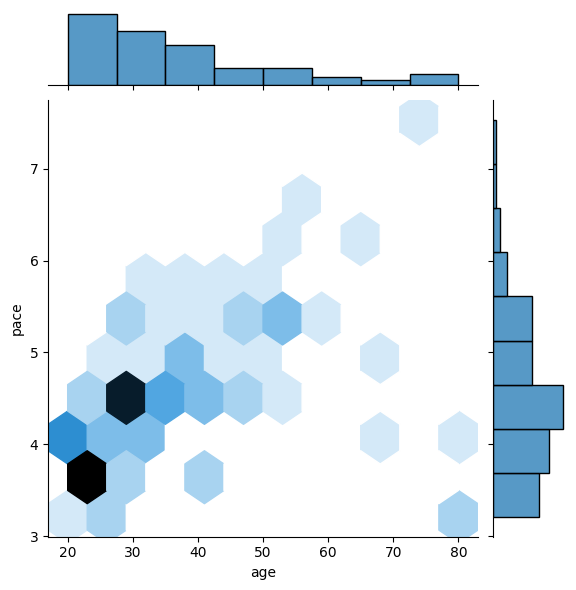

In [147]:
# Joint distribution plot with hexes
sns.jointplot(x="age", y="pace", data=run_data, kind="hex", gridsize=10)

# Maximum Likelihood Example - Laplace Distribution

<Axes: xlabel='data', ylabel='Count'>

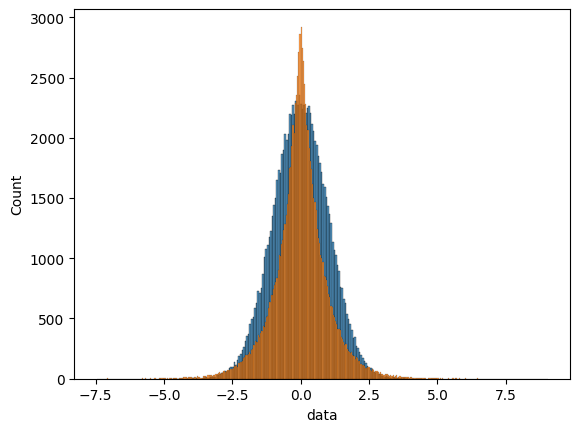

In [148]:
# Generate data
n = 100001
normalData = pd.DataFrame({"data": pd.Series(np.random.normal(0,1,n))})
laplaceData = pd.DataFrame({"data": pd.Series(np.random.laplace(0,1/np.sqrt(2),n))})

# Plot
sns.histplot(normalData.data)
sns.histplot(laplaceData.data)

(0.0, 200.0)

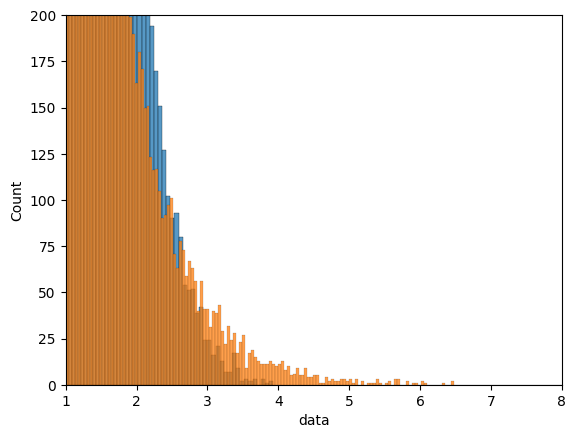

In [149]:
#Zoom in

sns.histplot(normalData.data)
sns.histplot(laplaceData.data)
plt.xlim(1,8)
plt.ylim(0,200)

$$\ell(y; \mu, b) = \log(2b) - |y - \mu| / b$$

In [6]:
## Laplace Negative Log Likelihood
def laplaceNegLogLikelihood(mu, b, y):
    neg_log_lik = -np.sum(np.log(2*b) - abs(y - mu) / b)
    return neg_log_lik

In [151]:
## Laplace Maximum Likelihood Estimate for mu
def maximumLikelihood(y):
    # For this demonstration I am fixing b = 1
    RES = so.minimize(laplaceNegLogLikelihood, 1, args=(1,y), method="Powell", tol=1e-8)
    print(RES)
    return RES.x

maximumLikelihood(laplaceData.values)

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1218.103553658672
       x: [ 8.060e-04]
     nit: 2
   direc: [[-4.252e-07]]
    nfev: 66


array([0.00080597])

In [152]:
# Should give same answer as median!
laplaceData.median()

data    0.000806
dtype: float64

In [153]:
# Laplace Negative Log Likelihood for regression
def laplaceRegNegLogLikelihood(beta, X, y):
    mu = X@beta
    return laplaceNegLogLikelihood(mu, 1, y)

In [154]:
# Function to maximize regression log likelihood
def maximumRegLikelihood(X, y, negloglik=laplaceRegNegLogLikelihood):
    ### BEGIN SOLUTION
    nrows,ncols = X.shape
    betas=np.zeros(ncols)
    RES = so.minimize(negloglik, betas, args=(X,y), method="Powell", tol=1e-8)
    print(RES)
    return RES.x

age = run_data.age.values
X = np.c_[np.ones(age.size), age]
y = run_data.pace.values

b,loss = maximumRegLikelihood(X,y)
   

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -8.79601856858332
       x: [ 3.335e+00  3.435e-02]
     nit: 7
   direc: [[-1.387e-01  4.623e-03]
           [-5.047e-05  9.346e-07]]
    nfev: 551


In [155]:
# Check against statsmodels - median regression
sad_fit = smf.quantreg('pace ~ age', data = run_data).fit(q = 0.5)
sad_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                   pace   Pseudo R-squared:               0.1344
Model:                       QuantReg   Bandwidth:                      0.8038
Method:                 Least Squares   Sparsity:                        1.891
Date:                Thu, 19 Sep 2024   No. Observations:                   79
Time:                        11:45:58   Df Residuals:                       77
                                        Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3352      0.278     11.995      0.000       2.782       3.889
age            0.0343      0.007      4.954      0.000       0.021       0.048
==============================================================================
"""